In [20]:
import pandas as pd
import subprocess
import os

from datetime import date
import json
import praw

import time
from nltk.stem import *
import re
import string 
import numpy as np

subreddit = "WorldNews"
today = date.today()
today = "{}-{}-{}".format(today.month, today.day, today.year)

# We can use a script that specifys which subreddit - decided to just go with postings, because comments introduce so much extra noise that is unneeded.

In [21]:
#This scrapes the postings
def scrape_postings(subreddit):
    subprocess.run(["./post_scraper.sh", subreddit], text=True, input="Y")
    return

#This scrapes the comments
def scrape_comments(data, subreddit, min_num_comments=1):
    for i in range(len(data)):
        if data["Comment Count"][i] >= min_num_comments:
            URL = "https://reddit.com/r/{}/comments/{}".format(subreddit, data["ID"][i])
            #We have a shell script called scrape_comments which goes to each individual post
            subprocess.call(["./comment_scraper.sh", URL])
    return

In [22]:
scrape_postings(subreddit)

In [23]:
data = pd.read_json("URS-master/scrapes/{}/r-{}-Top-1000-results-past-day.json".format(today,subreddit)).transpose()
data.head()

,Title,Flair,Date Created,Upvotes,Upvote Ratio,ID,Edited?,Is Locked?,NSFW?,Is Spoiler?,Stickied?,URL,Comment Count,Text
Post 1,The war on cocoa: Hershey Co. accused of not u...,None,12-13-2020 18:21:15,56341,0.93,kcfldu,False,False,False,False,False,https://www.nbcnews.com/business/business-news...,1665,
Post 2,Navalny poisoning: Russia made second assassin...,Russia,12-13-2020 10:21:28,27689,0.95,kc8cjf,False,False,False,False,False,https://www.dw.com/en/navalny-poisoning-russia...,869,
Post 3,Russia 'tried to assassinate opposition leader...,Russia,12-13-2020 22:31:02,12863,0.97,kckdmm,False,False,False,False,False,https://www.dailymail.co.uk/news/article-90482...,314,
Post 4,Canada-U.S. border closure extended to Jan. 21...,COVID-19,12-13-2020 17:09:22,9801,0.97,kce8ij,False,False,False,False,False,https://globalnews.ca/news/7518359/coronavirus...,462,
Post 5,Major leak 'exposes' members and 'lifts the li...,None,12-13-2020 11:00:07,9279,0.9,kc8ra5,False,False,False,False,False,https://www.skynews.com.au/details/_6215946537...,670,


# If we leave the script running on a daily basis, it will scrape that dates results for the subreddit specified.

In [24]:
#scrape_comments(data, subreddit)

#Stuffing all the comments into a pandas dataframe

"""
out = pd.DataFrame()
for file in os.listdir("URS-master/scrapes/{}".format(today)):
    if file[0] == "c":
        f = json.load(open("URS-master/scrapes/{}/{}".format(today,file)))
        f = pd.DataFrame(f).transpose()
        out = out.append(f)
        
out.columns = ["Comment_Info"]
out.head
"""

'\nout = pd.DataFrame()\nfor file in os.listdir("URS-master/scrapes/{}".format(today)):\n    if file[0] == "c":\n        f = json.load(open("URS-master/scrapes/{}/{}".format(today,file)))\n        f = pd.DataFrame(f).transpose()\n        out = out.append(f)\n        \nout.columns = ["Comment_Info"]\nout.head\n'

In [25]:
#Stuffing all the posts into a dataframe

data = pd.read_json("URS-master/scrapes/{}/r-{}-Top-1000-results-past-day.json".format(today,subreddit)).transpose()
data = data.sort_values("Comment Count")

postings = {}
for i in range(len(data)):
    post = {}
    for col in data:
        if data[col][i] == None:
            pass
        else:
            post[col] = data[col][i]
    post["Comment ID"] = data["ID"][i]
    postings[data["ID"][i]] = post

idx = postings.keys()
postings = pd.DataFrame([postings.values()]).transpose()
postings.index = idx
postings.columns = ["Comment_Info"]
postings

,Comment_Info
kc74nh,{'Title': 'Thailand on Sunday recorded 17 new ...
kce5gn,{'Title': 'Iran controls oil pipeline spillage...
kc7wci,{'Title': 'Pakistan Decides Against New Coal-f...
kc7qpw,{'Title': 'Bahrain approves Chinese COVID-19 v...
kcrgcv,{'Title': 'New Zealand and Australia agree on ...
...,...
kcawsy,{'Title': 'No-deal Brexit means UK poised to l...
kc8ra5,{'Title': 'Major leak 'exposes' members and 'l...
kc8cjf,{'Title': 'Navalny poisoning: Russia made seco...
kcc6g4,{'Title': 'Supermarkets 'told to stockpile foo...


In [26]:
#Combining the two!
#We know that a row is a Posting if there is a "Title" field
#out = out.append(postings)
#data = pd.json_normalize(out['Comment_Info'])
data = pd.json_normalize(postings['Comment_Info'])

#Selecting only the relevant fields
#data = data[["Parent ID", "Comment ID", "Date Created", "Upvotes", "Text", "Title", "Upvote Ratio","Comment Count"]]
data = data[["Comment ID", "Date Created", "Upvotes", "Text", "Title", "URL", "Upvote Ratio","Comment Count"]]
data["Text"] = data["Title"] + " " + data["Text"]

data

,Comment ID,Date Created,Upvotes,Text,Title,URL,Upvote Ratio,Comment Count
0,kc74nh,12-13-2020 08:24:16,49,Thailand on Sunday recorded 17 new cases of th...,Thailand on Sunday recorded 17 new cases of th...,https://www.bangkokpost.com/thailand/general/2...,0.82,0
1,kce5gn,12-13-2020 17:04:34,20,"Iran controls oil pipeline spillage, fire in s...","Iran controls oil pipeline spillage, fire in s...",https://www.reuters.com/article/uk-iran-pipeli...,0.77,0
2,kc7wci,12-13-2020 09:38:53,35,Pakistan Decides Against New Coal-fired Power,Pakistan Decides Against New Coal-fired Power,https://www.voanews.com/south-central-asia/pak...,0.71,0
3,kc7qpw,12-13-2020 09:23:48,37,Bahrain approves Chinese COVID-19 vaccine for ...,Bahrain approves Chinese COVID-19 vaccine for use,https://apnews.com/article/bahrain-dubai-saudi...,0.78,0
4,kcrgcv,12-14-2020 05:27:35,12,New Zealand and Australia agree on quarantine-...,New Zealand and Australia agree on quarantine-...,https://www.bbc.co.uk/news/world-asia-55298324,0.69,0
...,...,...,...,...,...,...,...,...
144,kcawsy,12-13-2020 13:50:05,4732,No-deal Brexit means UK poised to lose access ...,No-deal Brexit means UK poised to lose access ...,https://www.independent.co.uk/news/uk/politics...,0.97,502
145,kc8ra5,12-13-2020 11:00:07,9279,Major leak 'exposes' members and 'lifts the li...,Major leak 'exposes' members and 'lifts the li...,https://www.skynews.com.au/details/_6215946537...,0.90,670
146,kc8cjf,12-13-2020 10:21:28,27689,Navalny poisoning: Russia made second assassin...,Navalny poisoning: Russia made second assassin...,https://www.dw.com/en/navalny-poisoning-russia...,0.95,869
147,kcc6g4,12-13-2020 15:12:51,9066,Supermarkets 'told to stockpile food' as fears...,Supermarkets 'told to stockpile food' as fears...,https://www.theguardian.com/politics/2020/dec/...,0.96,1041


# Decided to just use headline titles, as comments introduced too much noise.

Text(0.5, 1.0, 'r/WorldNews Dec 13 Posting Length Distribution')

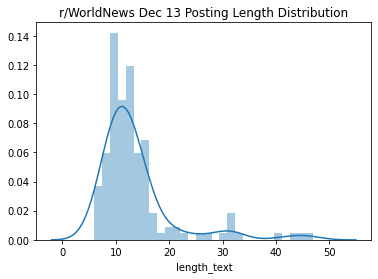

In [27]:
import seaborn as sns
data["length_text"] = data["Text"].apply(lambda x: len(x.split(" ")))
g = sns.distplot(data["length_text"])
g.set_title("r/WorldNews Dec 13 Posting Length Distribution")

In [28]:
g = sns.distplot(data["length_title"])
g.set_title("Cornell Dec 10 Title Length Distribution")

KeyError: 'length_title'

# Preprocessing the data

In [29]:
from collections import Counter
import nltk
from nltk.corpus import stopwords

ps = PorterStemmer()

data["Cleaned Text"] = data["Title"].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
data["Cleaned Text"] = data["Cleaned Text"].apply(lambda x: x.replace("\n", ""))
data["Cleaned Text"] = data["Cleaned Text"].apply(lambda x: [ps.stem(i.lower()) for i in str(x).split(" ")])
data["Cleaned Text"] = data["Cleaned Text"].apply(lambda x: [i for i in x if i not in stopwords.words('english')])
data["Cleaned Text"] = data["Cleaned Text"].apply(lambda x: " ".join(x))
#Length of text is a feature

#Turning time active as a feature to see freshness
data["Date Created"] = pd.to_datetime(data['Date Created'])
data["Time elapsed (mins)"] = (data['Date Created'] - min(data["Date Created"])).astype("timedelta64[m]")

#Seeing if there is an image 
data["has image"] = data["URL"].apply(lambda x: x[-4:] == ".jpg")

#Categorizing Comment Upvotes by Range of Upvotes
ratios = max(data["Upvote Ratio"])

data["Hated Comment"] = data["Upvotes"].apply(lambda x: x <=  np.percentile(ratios, 25))
data["Disliked Comment"] = data["Upvotes"].apply(lambda x: np.percentile(ratios, 25) < x <=  np.percentile(ratios, 50))
data["Likable Comment"] = data["Upvotes"].apply(lambda x: np.percentile(ratios, 50) < x <=  np.percentile(ratios, 75))
data["Loved Comment"] = data["Upvotes"].apply(lambda x: np.percentile(ratios, 75) < x <=  np.percentile(ratios, 100))

#Categorizing the different types of comment ids and their parents
#comment_ID = pd.get_dummies(data["Comment ID"])
#data["Parent ID"] = data["Parent ID"].fillna("t0_None")
#parent_level = pd.get_dummies(data["Parent ID"])
#data = pd.concat([data, comment_ID,parent_level],axis=1)

keep = data[data.columns[[0,1,2,3,4,5,9]]]
vectors = data[data.columns[[6,7,8] + [i for i in range(10,len(data.columns))]]]

# Taking a look at just TFIDF Embeddings for Baseline

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer()
x = v.fit_transform(keep['Cleaned Text'])
tfidf = pd.DataFrame(x.toarray(), columns=v.get_feature_names())

# Elbow Method to Determine Optimal Clusters -dont run this only did this for the graph.

In [32]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 

K = range(1,len(vectors)) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(tfidf) 
    kmeanModel.fit(tfidf)     
      
    distortions.append(sum(np.min(cdist(tfidf, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / tfidf.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(tfidf, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / tfidf.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 
    
sns.lineplot(x=range(1,len(vectors)), y=distortions)

KeyboardInterrupt: 

# There does not seem to be an optimal elbow cluster, so we will do half of the number of headlines.

# Print out the headlines from the clusters

In [35]:
import hdbscan 
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, gen_min_span_tree=True)
clusterer.fit(tfidf)
keep["tfidf label"] = clusterer.labels_

#Looking at the most common words in each label

from collections import Counter
import nltk
from nltk.corpus import stopwords

x = keep.groupby("tfidf label").count()["Text"]
x =  pd.DataFrame(x)
x = x[x["Text"] > 1]

#Getting all words associated with particular label
out = dict()
for label in x.index:
    corpus = []
    for index in keep[keep["tfidf label"] == label].index:
        for word in keep["Title"][index].split():
            if word not in stopwords.words("english"):
                corpus.append(word.lower())
    out[label] = Counter(corpus)


for label in x.index:
    texts = keep[keep["tfidf label"] == label]    
    for index in texts.index:
        print("\t", texts["Title"][index])
    print("-----------------------------------------------")

	 Farmers plan to block Jaipur highway; Police step up vigil on Delhi-Haryana border points
	 AstraZeneca to buy Alexion for $39 billion to expand in immunology
	 Silent nights: Germany tightens lockdown over festive period
	 Report: Likud lawmaker David Bitan hospitalized in ICU after COVID-19 diagnosis
	 Italy bans Christmas travel between regions
	 Christmas cyclone: Yasa forms near Fiji, possible threat to New Zealand
	 Kenya to compensate rape victims from violence 13 years ago
	 Turkey confirms Iran’s kidnapping of former ASMLA leader Habib Chaab on its soil
	 Alarm as Ethiopia returns refugees who fled Tigray fighting
	 China moon probe begins journey back to Earth
	 Jihadists push Mozambicans out of the countryside in to Pemba
	 Geminid meteor shower to light up Australian skies in stellar week for stargazers
	 After battling virus, Algerian leader suddenly reappears
	 Brexit: UK car production 'could halt early next year' if EU trade talks fail, union warns
	 Syria makes comma

/home/jasonwonton/.local/lib/python3.7/site-packages/hdbscan/hdbscan_.py:219: UserWarning: Cannot generate Minimum Spanning Tree; the implemented Prim's does not produce the full minimum spanning tree 
  'the full minimum spanning tree ', UserWarning)
/home/jasonwonton/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [38]:
keep

,Comment ID,Date Created,Upvotes,Text,Title,URL,Cleaned Text,tfidf label
0,kc74nh,2020-12-13 08:24:16,49,Thailand on Sunday recorded 17 new cases of th...,Thailand on Sunday recorded 17 new cases of th...,https://www.bangkokpost.com/thailand/general/2...,thailand sunday record 17 new case novel coron...,17
1,kce5gn,2020-12-13 17:04:34,20,"Iran controls oil pipeline spillage, fire in s...","Iran controls oil pipeline spillage, fire in s...",https://www.reuters.com/article/uk-iran-pipeli...,iran control oil pipelin spillag fire southwest,16
2,kc7wci,2020-12-13 09:38:53,35,Pakistan Decides Against New Coal-fired Power,Pakistan Decides Against New Coal-fired Power,https://www.voanews.com/south-central-asia/pak...,pakistan decid new coalfir power,5
3,kc7qpw,2020-12-13 09:23:48,37,Bahrain approves Chinese COVID-19 vaccine for ...,Bahrain approves Chinese COVID-19 vaccine for use,https://apnews.com/article/bahrain-dubai-saudi...,bahrain approv chines covid19 vaccin use,19
4,kcrgcv,2020-12-14 05:27:35,12,New Zealand and Australia agree on quarantine-...,New Zealand and Australia agree on quarantine-...,https://www.bbc.co.uk/news/world-asia-55298324,new zealand australia agre quarantinefre trave...,26
...,...,...,...,...,...,...,...,...
144,kcawsy,2020-12-13 13:50:05,4732,No-deal Brexit means UK poised to lose access ...,No-deal Brexit means UK poised to lose access ...,https://www.independent.co.uk/news/uk/politics...,nodeal brexit mean uk pois lose access secur d...,-1
145,kc8ra5,2020-12-13 11:00:07,9279,Major leak 'exposes' members and 'lifts the li...,Major leak 'exposes' members and 'lifts the li...,https://www.skynews.com.au/details/_6215946537...,major leak expos member lift lid chines commun...,6
146,kc8cjf,2020-12-13 10:21:28,27689,Navalny poisoning: Russia made second assassin...,Navalny poisoning: Russia made second assassin...,https://www.dw.com/en/navalny-poisoning-russia...,navalni poison russia made second assassin att...,9
147,kcc6g4,2020-12-13 15:12:51,9066,Supermarkets 'told to stockpile food' as fears...,Supermarkets 'told to stockpile food' as fears...,https://www.theguardian.com/politics/2020/dec/...,supermarket told stockpil food fear grow nodea...,23


In [37]:
keep.groupby("tfidf label").count()

,Comment ID,Date Created,Upvotes,Text,Title,URL,Cleaned Text
tfidf label,,,,,,,
-1,48,48,48,48,48,48,48
0,4,4,4,4,4,4,4
1,2,2,2,2,2,2,2
2,3,3,3,3,3,3,3
3,2,2,2,2,2,2,2
4,3,3,3,3,3,3,3
5,2,2,2,2,2,2,2
6,2,2,2,2,2,2,2
7,7,7,7,7,7,7,7


# We see here that many of the topics with similar words are bound together, and this  alone is pretty good!

# LDA - https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#14computemodelperplexityandcoherencescore

In [13]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

data_words = keep["Cleaned Text"].apply(lambda x: x.split(" "))
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=2, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

doc_lda = lda_model[corpus]
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds='mmds')
vis

/usr/lib/python3/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.024788  0.078249       1        1  52.979721
1      0.024788 -0.078249       2        1  47.020287, topic_info=           Term      Freq      Total Category  logprob  loglift
103          us  6.000000   6.000000  Default  30.0000  30.0000
107      execut  7.000000   7.000000  Default  29.0000  29.0000
109  journalist  7.000000   7.000000  Default  28.0000  28.0000
148          un  7.000000   7.000000  Default  27.0000  27.0000
72        polic  5.000000   5.000000  Default  26.0000  26.0000
..          ...       ...        ...      ...      ...      ...
12         pari  2.704012   5.228970   Topic2  -5.7305   0.0951
252              3.036904  12.394922   Topic2  -5.6144  -0.6519
528      worker  2.513047   4.782962   Topic2  -5.8038   0.1110
677         use  2.502814   4.321140   Topic2  -5.8079   0.2085
255      climat  2.506471  11.346134   Topic2  -5.8064  -0.7554

[125 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
252       1  0.726104        
252       2  0.242035        
429       1  0.856421    2017
688       1  0.233665     arm
688       2  0.700995     arm
...     ...       ...     ...
528       1  0.418151  worker
528       2  0.627226  worker
158       1  0.758711   world
158       2  0.303484   world
111       1  1.019579     zam

[122 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

# Coherence to see optimal number of topics for LDA, seems like optimal is 1-2 topics.

In [14]:
perplexity = []
coherence = []

for k in range(1, 50):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence.append(coherence_lda)

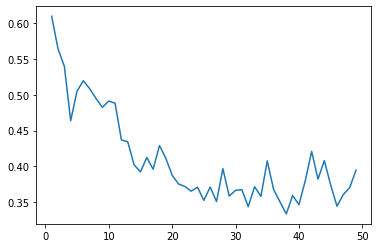

In [15]:
sns.lineplot(x=range(1,50), y=coherence)

# Start of BERT stuff - this is the best.

In [39]:
from sentence_transformers import SentenceTransformer
import numpy as np

model = SentenceTransformer('bert-large-uncased')
BERT = keep["Title"].apply(lambda x: model.encode(x))

BERT = pd.DataFrame(data=BERT.values.tolist())
BERT.head()

Exception when trying to download https://sbert.net/models/bert-large-uncased.zip. Response 404


,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,-0.515457,-0.122144,-0.300409,-0.103546,-0.474084,-0.154626,0.426094,-0.063597,0.058395,0.582794,...,0.067202,0.446083,-0.484475,-0.236021,0.102296,0.461837,0.082011,0.033214,-0.150731,0.217826
1,-0.426906,0.191278,-0.005904,-0.084639,-0.290087,-0.068055,0.368814,0.048103,0.285799,0.592420,...,-0.113331,0.056432,-0.715368,0.168997,0.353817,0.349617,0.072495,-0.304065,-0.347684,0.278669
2,-0.577789,0.077807,-0.237919,0.049602,-0.295715,0.150985,0.397404,-0.191512,-0.038135,0.448254,...,-0.036729,0.023501,-0.731552,0.112383,0.197149,0.638868,0.348537,-0.312049,-0.324688,-0.099797
3,-0.580298,-0.058885,-0.058435,0.085807,-0.199203,0.132014,0.438735,-0.072046,-0.163776,0.378469,...,-0.168615,0.259830,-0.478976,-0.222807,0.220182,0.589823,-0.354218,0.209087,-0.367761,-0.294737
4,-0.754402,0.111922,-0.103300,-0.071000,-0.560524,0.125989,0.551018,-0.219073,-0.070703,0.657951,...,-0.206434,-0.010918,-0.635967,-0.147369,-0.040819,0.542090,0.336517,-0.333421,-0.317619,0.230141


# Elbow Method to Determine Optimal Clusters

/home/jasonwonton/.local/lib/python3.7/site-packages/ipykernel_launcher.py:16: ConvergenceWarning: Number of distinct clusters (164) found smaller than n_clusters (165). Possibly due to duplicate points in X.
  app.launch_new_instance()
/home/jasonwonton/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: ConvergenceWarning: Number of distinct clusters (164) found smaller than n_clusters (165). Possibly due to duplicate points in X.
/home/jasonwonton/.local/lib/python3.7/site-packages/ipykernel_launcher.py:16: ConvergenceWarning: Number of distinct clusters (164) found smaller than n_clusters (166). Possibly due to duplicate points in X.
  app.launch_new_instance()
/home/jasonwonton/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: ConvergenceWarning: Number of distinct clusters (164) found smaller than n_clusters (166). Possibly due to duplicate points in X.
/home/jasonwonton/.local/lib/python3.7/site-packages/ipykernel_launcher.py:16: ConvergenceWarning: Number of

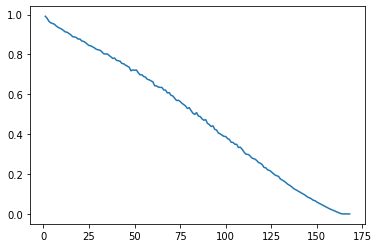

In [17]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 

K = range(1,len(vectors)) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(tfidf) 
    kmeanModel.fit(tfidf)     
      
    distortions.append(sum(np.min(cdist(tfidf, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / tfidf.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(tfidf, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / tfidf.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 
    
sns.lineplot(x=range(1,len(vectors)), y=distortions)

# Function to cluster embeddings

In [40]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, gen_min_span_tree=True)
clusterer.fit(BERT)
keep["BERT label"] = clusterer.labels_

#Looking at the most common words in each label

x = keep.groupby("BERT label").count()["Text"]
x =  pd.DataFrame(x)
x = x[x["Text"] > 1]

#Getting all words associated with particular label
out = dict()
for label in x.index:
    corpus = []
    for index in keep[keep["BERT label"] == label].index:
        for word in keep["Title"][index].split():
            if word not in stopwords.words("english"):
                corpus.append(word.lower())
    out[label] = Counter(corpus)

count = 0
l = 0
for label in x.index:
    l += 1
    texts = keep[keep["BERT label"] == label]    
    for index in texts.index:
        count += 1
        print("\t", texts["Title"][index])
    print("-----------------------------------------------")

	 Iran controls oil pipeline spillage, fire in southwest
	 Pakistan Decides Against New Coal-fired Power
	 AstraZeneca to buy Alexion for $39 billion to expand in immunology
	 Nepal on Sunday reported 830 new cases of coronavirus, as of today, 235,731 individuals have recovered, the total death-toll is 1,698
	 Silent nights: Germany tightens lockdown over festive period
	 Report: Likud lawmaker David Bitan hospitalized in ICU after COVID-19 diagnosis
	 Italy bans Christmas travel between regions
	 Christmas cyclone: Yasa forms near Fiji, possible threat to New Zealand
	 COVID-19 Runs Unchecked in Pakistan's Overcrowded Prisons
	 Kenya to compensate rape victims from violence 13 years ago
	 Japan, South Korea set new daily records, mull steps
	 Paris Accords five years on: UN secretary-general calls for leaders to declare 'climate emergency'
	 Alarm as Ethiopia returns refugees who fled Tigray fighting
	 Nearly 150 arrested at Paris protest over security bill
	 Almost 20 dead in a sinki

/home/jasonwonton/.local/lib/python3.7/site-packages/hdbscan/hdbscan_.py:219: UserWarning: Cannot generate Minimum Spanning Tree; the implemented Prim's does not produce the full minimum spanning tree 
  'the full minimum spanning tree ', UserWarning)
/home/jasonwonton/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# We have reduced 160 headlines 79 headlines, a reduction of 49.375%.

# BERT + Heuristics of Upvotes, Time Active, Has an Image or not as features. The introduction of these heuristics actually introduces noise, resulting in poorer labelling. Just using BERT for the postings of the day is enough. 

In [19]:
BERT_heuristics = pd.concat([BERT, vectors],axis=1)
kmeans = KMeans(n_clusters=50).fit(BERT_heuristics)
keep["BERT + Heuristic label"] = kmeans.labels_

#Looking at the most common words in each label

x = keep.groupby("BERT + Heuristic label").count()["Text"]
x =  pd.DataFrame(x)
x = x[x["Text"] > 1]

#Getting all words associated with particular label
out = dict()
for label in x.index:
    corpus = []
    for index in keep[keep["BERT + Heuristic label"] == label].index:
        for word in keep["Title"][index].split():
            if word not in stopwords.words("english"):
                corpus.append(word.lower())
    out[label] = Counter(corpus)


for label in x.index:
    texts = keep[keep["BERT + Heuristic label"] == label]    
    for index in texts.index:
        print("\t", texts["Title"][index])
    print("-----------------------------------------------")

	 Anglo American to divest from thermal coal operations by 2023
	 Malaysia's Top Glove fired whistleblower before virus outbreak
-----------------------------------------------
	 Poland sees COVID-19 vaccination capacity at 3.4 million doses a month
	 AstraZeneca to acquire Alexion in $39 billion deal
	 Climate change: UK to end aid for fossil fuel projects abroad
	 Belgium eases restrictions on Mass celebrated with the public, permitting a maximum of 15 people to participate in the liturgy from Sunday
	 New COVID-19 restrictions imminent in Lithuania as medics swamped with new patients are forced to choose who gets a chance at recovery
	 ‘Foreign manoeuvres’ in Western Sahara destablising Algeria: PM
	 Navy boats on standby to protect UK waters in case of no-deal Brexit
	 France attempted to hide award ceremony featuring Egyptian leader Abdel Fattah al-Sisi
	 COVID-19 impacting mental health of medical professionals
	 Nearly half of care home staff won't take Covid vaccine as bosses c

/home/jasonwonton/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [41]:
keep.groupby("tfidf label").count()

,Comment ID,Date Created,Upvotes,Text,Title,URL,Cleaned Text,BERT label
tfidf label,,,,,,,,
-1,48,48,48,48,48,48,48,48
0,4,4,4,4,4,4,4,4
1,2,2,2,2,2,2,2,2
2,3,3,3,3,3,3,3,3
3,2,2,2,2,2,2,2,2
4,3,3,3,3,3,3,3,3
5,2,2,2,2,2,2,2,2
6,2,2,2,2,2,2,2,2
7,7,7,7,7,7,7,7,7


# Fasttext model instead - more inaccurate than BERT.

In [20]:
import fasttext
train_set = data["Title"]
train_set = train_set.reset_index(drop=True)
train_set

0      Angela Merkel to discuss tighter lockdown with...
1      Dozens arrested at Paris protest over proposed...
2      The dead professor and the vast pro-India disi...
3      Azerbaijani forces attempt attack in southern ...
4      TenneT Starts Trial Operation of NordLink: The...
                             ...                        
164    Swedish Covid Workers Are Quitting, Leaving IC...
165    Brexit: Armed Royal Navy boats on standby to p...
166    Food meant for British supermarkets is becomin...
167     Swiss freeze assets of Belarus leader Lukashenko
168    Greta Thunberg Says She's 'More Than Happy' Th...
Name: Title, Length: 169, dtype: object

In [21]:
import fasttext.util

with open("train.txt", "a") as f:
    for sentence in train_set:
        f.write("{}\n".format(sentence))

model = fasttext.train_unsupervised('train.txt', model='skipgram')


fasttext.util.download_model('en', if_exists='ignore')  # English
model = fasttext.load_model('cc.en.300.bin')

#Gets average word vector of sentence
def encode_sentence(sentence):
    out = np.zeros(300)
    count = 1
    for text in sentence.split():
        out += model[text]
        count += 1
    return out / count

fasttext = pd.DataFrame(data["Title"].apply(lambda x: encode_sentence(str(x))).values.tolist())
fasttext

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.021687,0.065882,0.003500,0.029919,-0.037365,-0.007504,0.043235,0.010091,0.003368,0.002682,...,0.035145,-0.005492,-0.041328,-0.028739,0.011389,-0.005282,0.016659,0.052718,0.029185,-0.001182
1,0.007435,0.051410,0.020169,0.008191,-0.031156,0.006433,0.002811,0.028339,0.014882,0.001423,...,0.028293,0.015219,-0.088891,0.029400,0.008133,-0.003633,0.024337,0.036178,0.060405,0.013385
2,-0.033413,-0.045223,-0.005184,-0.030787,-0.021419,0.006193,0.017500,0.005410,-0.043234,-0.036677,...,0.013174,0.013628,-0.077426,0.029085,-0.011761,-0.030884,-0.007537,0.158537,0.021369,-0.002491
3,-0.031829,-0.044816,0.037618,-0.038486,-0.028165,0.001696,0.004912,-0.000264,-0.007898,-0.015227,...,-0.015010,0.009105,-0.012557,0.005187,-0.022756,-0.002681,-0.012582,0.065341,0.009540,0.013290
4,-0.029579,-0.021396,0.014484,-0.004619,-0.028228,0.010412,-0.012021,0.021397,-0.005002,-0.011040,...,0.003094,0.013178,-0.019145,0.003336,-0.002919,-0.009342,-0.003620,0.090574,-0.007871,-0.013443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,0.021628,-0.029271,0.009586,0.039372,-0.001543,0.000018,-0.005969,-0.002262,0.053718,0.037629,...,-0.015729,-0.002836,-0.004619,-0.038146,-0.000800,0.033155,0.039271,0.027429,0.061905,-0.039804
165,-0.025220,-0.022211,0.021670,-0.017345,-0.047708,0.024677,0.070402,0.033447,0.007367,-0.007417,...,0.018146,0.017993,-0.083064,-0.070296,-0.027867,0.004277,-0.006437,0.169583,-0.045991,-0.023367
166,-0.021694,-0.013622,-0.021769,0.013942,-0.029299,0.015753,0.020184,0.024085,-0.005692,-0.001436,...,0.049300,0.021772,-0.061797,-0.025636,-0.014888,0.011027,-0.017019,0.105788,-0.028520,0.024204
167,0.017951,-0.055933,0.003171,-0.044208,-0.010452,0.011294,0.019567,-0.006053,0.006097,-0.026918,...,-0.055939,0.007550,0.003107,0.008888,-0.038279,0.017529,0.021527,0.051919,0.029435,-0.019967


In [22]:
kmeans = KMeans(n_clusters=80).fit(fasttext)
keep["fasttext label"] = kmeans.labels_

#Looking at the most common words in each label

x = keep.groupby("fasttext label").count()["Text"]
x =  pd.DataFrame(x)
x = x[x["Title"] > 1]

#Getting all words associated with particular label
out = dict()
for label in x.index:
    corpus = []
    for index in keep[keep["fasttext label"] == label].index:
        for word in keep["Title"][index].split():
            if word not in stopwords.words("english"):
                corpus.append(word.lower())
    out[label] = Counter(corpus)

count = 0
l = 0
for label in x.index:
    l += 1
    texts = keep[keep["fasttext label"] == label]    
    for index in texts.index:
        count += 1
        print("\t", texts["Title"][index])
    print("-----------------------------------------------")

	 Tigray conflict: First aid convoy reaches capital of Ethiopian region hit by fighting | World News
	 Mexican photojournalist killed after taking photos of bodies along a road | Mexico
-----------------------------------------------
	 Bolivia approves first same-sex union following legal battle
	 Anti-Farm law activists deface Mahatma Gandhi statue in Washington; ‘Khalistani’ flags sighted
	 Bolivia approves first same-sex union following legal battle
	 Bolivia approves first same-sex union following legal battle. Bolivia’s Constitutional Court previously ruled that domestic laws should be consistent with international human rights obligations.
	 Argentina's lower house passes bill legalizing abortion
	 First woman detained under India's controversial Love Jihad laws 'forced into miscarriage'
-----------------------------------------------
	 France attempted to hide award ceremony featuring Egyptian leader Abdel Fattah al-Sisi
	 Israel, Morocco agree to normalize relations with minima

/home/jasonwonton/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
